In [1]:
import pandas as pd
from numpy import random,argmax,array,take
import matplotlib.pyplot as plt
import string 
import re
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.callbacks import ModelCheckpoint

from keras.models import load_model
from keras import optimizers
%matplotlib inline

In [15]:
data =pd.read_csv("eng_-french.csv")
# data=data.drp("Unnamed: 0")
# data=array(data)

data=array(data)

In [5]:
import spacy

# Load the English model
nlp = spacy.load('en_core_web_sm')
def preprocess_text(text):
    # Tokenization and Lemmatization
    doc = nlp(text)
    tokens = [token.lemma_.lower().strip() for token in doc if not token.is_punct and not token.is_space]
    
    # Removing stopwords
    tokens = [token for token in tokens if not nlp.vocab[token].is_stop]
    
    # Joining tokens back into a single string
    processed_text = ' '.join(tokens)
    
    return processed_text


In [16]:
data[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in data[:,0]]
data[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in data[:,1]]


In [19]:
for i in range(len(data)):
    data[i,0] = data[i,0].lower()
    data[i,1] = data[i,1].lower()

In [20]:
eng_l = []
deu_l = []

In [21]:
for i in data[:,0]:
      eng_l.append(len(i.split()))

for i in data[:,1]:
      deu_l.append(len(i.split()))


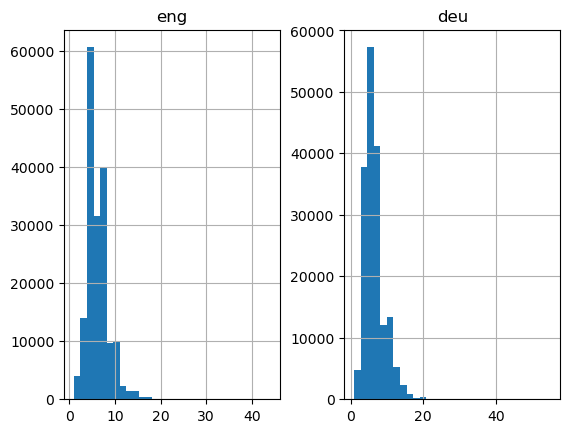

In [22]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()


In [23]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [24]:
eng_tokenizer = tokenization(data[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

In [30]:
deu_tokenizer = tokenization(data[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1
deu_length = 8
eng_length = 8

In [31]:
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
        seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
        seq = pad_sequences(seq, maxlen=length, padding='post')
        return seq
 

In [32]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(data, test_size=0.2, random_state = 12)

In [35]:
from keras_preprocessing.sequence import pad_sequences
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])


In [36]:
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
        model = Sequential()
        model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
        model.add(LSTM(units))
        model.add(RepeatVector(out_timesteps))
        model.add(LSTM(units, return_sequences=True))
        model.add(Dense(out_vocab, activation='softmax'))
        return model

In [37]:
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')


C:\Users\USER\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [39]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=3, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

In [38]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

OSError: No file or directory found at model.h1.24_jan_19